In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
!pip3 install lightgbm

In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/ff/qq7gr6hd4mn0q9pyh7jkm77w0000gn/T/pip-req-build-9g9733xg
  Running command git clone -q https://github.com/openai/CLIP.git /private/var/folders/ff/qq7gr6hd4mn0q9pyh7jkm77w0000gn/T/pip-req-build-9g9733xg
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620


In [4]:
import clip

In [5]:
path="/Users/artemslepnev/Downloads/train_dataset_train"

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [6]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(f"/content/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [7]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [8]:
# читаем датасет
data_df = pd.read_csv("content/train.csv")

In [9]:
data_df.head(3)

,ID_img,class
0,220301124100_d3815192b7a85e54f935936bbe09496f.jpg,0.0
1,220301124101_c919e95934b3df93a6149764a498b11f.jpg,0.0
2,220301124110_69dcd5eb441c4df666dfedde7ac47fc6.jpg,0.0


<AxesSubplot:xlabel='class', ylabel='count'>

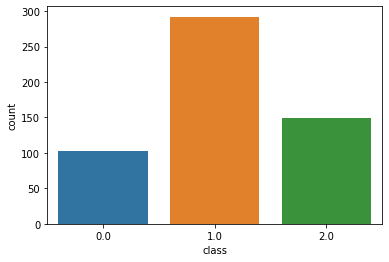

In [10]:
import seaborn as sns
import warnings
 
warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

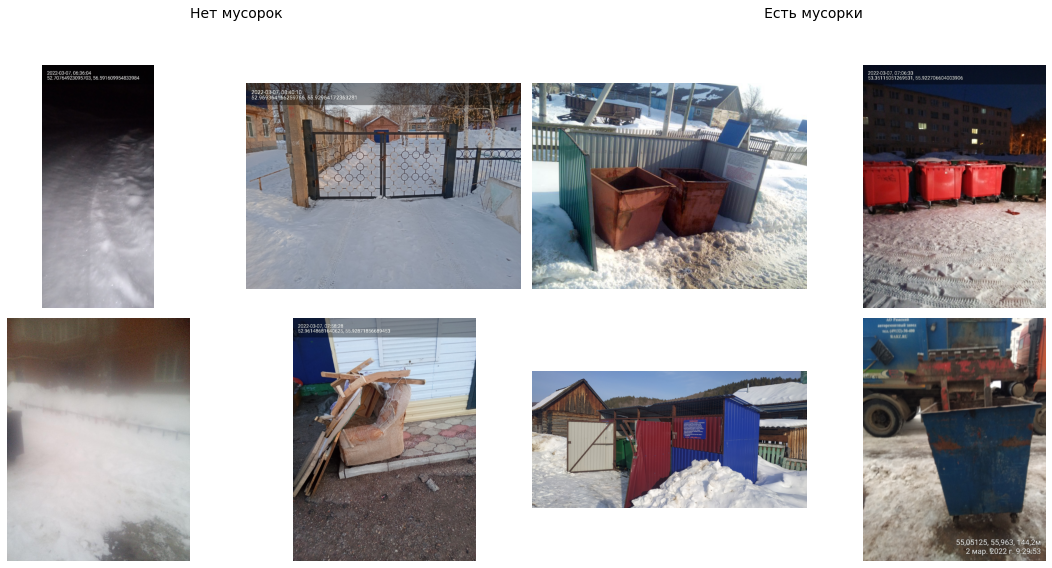

In [11]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Нет мусорок {" "*105} Есть мусорки', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"content/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"content/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

## CLIP embeddings

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [13]:
feats = []
with torch.no_grad():
    for i, df in tqdm(data_df.iterrows(), total=len(data_df)):
        image = preprocess(Image.open(f"content/train/{df['ID_img']}")).unsqueeze(0).to(device)
        image_features = model.encode_image(image)
        feats.append(image_features.cpu().numpy().flatten().tolist())

100%|█████████████████████████████████████████| 543/543 [01:31<00:00,  5.95it/s]


In [14]:
train_feats = np.array(feats)

In [15]:
np.save('train_feats.npy', train_feats)

In [16]:
test_df = pd.read_csv('sample_solution.csv')

In [17]:
feats = []
with torch.no_grad():
    for i, df in tqdm(test_df.iterrows(), total=len(test_df)):
        image = preprocess(Image.open(glob.glob(f"test_dataset_test/{df['ID_img']}*")[0])).unsqueeze(0).to(device)
        image_features = model.encode_image(image)
        feats.append(image_features.cpu().numpy().flatten().tolist())

100%|█████████████████████████████████████████| 225/225 [00:37<00:00,  6.05it/s]


In [18]:
test_feats = np.array(feats)

In [19]:
np.save('test_feats.npy', test_feats)

## lgbm

In [20]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [21]:
model = LGBMClassifier(n_estimators=1000, objective='multiclass')

In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(model, train_feats, data_df['class'], scoring='accuracy', cv=cv)

In [ ]:
np.mean(cv_scores)

In [143]:
model.fit(train_feats, data_df['class'])
test_df['class'] = model.predict(test_feats)

In [144]:
test_df.to_csv('submission_2.csv', index=False)

In [147]:
test_df['class'].value_counts()

1.0    173
0.0     32
2.0     20
Name: class, dtype: int64